## Introduction

In the following notebook we are going to be **create a pipeline and model** for sentiment analysis on a collection of tweets about Apple Inc. After preprocessing, the tweets are labeled as either positive (i.e. I love the new iMac) or negative. (i.e. Apple has bad work poilicies!)

## Data Description

* Tweet Sentiment: Positive Sentiment = 1, Negative Sentiment = 0
* Sentiment Confidence: Range of (0,1) describing the confidence of the sentiment assignment.
* Text: Text composition of the tweet

### Importing Libraries 

In [12]:
import nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

### Reading the Dataset

In [13]:
df = pd.read_csv('clean_apple.csv',encoding='latin-1',index_col=0)
df.head()

,sentiment,sentiment_confidence,text
0,1,0.8468,top 3 all tablets damn right!
1,1,0.6736,cnbctv apple's margins better than expected?...
2,0,1.0000,wtf my battery was 31 one second ago and now ...
3,1,1.0000,rt bought my at the store pretty good logo...
4,0,1.0000,contact sync between yosemite and ios8 is ser...


## Data Tokenisation

In [14]:
from nltk.tokenize import RegexpTokenizer

## NLTK tokenizer

tokenizer = RegexpTokenizer(r'\w+')     ## This regular expression breaks a line into words
df['tokens'] = df['text'].apply(tokenizer.tokenize)
df.head()

,sentiment,sentiment_confidence,text,tokens
0,1,0.8468,top 3 all tablets damn right!,"[top, 3, all, tablets, damn, right]"
1,1,0.6736,cnbctv apple's margins better than expected?...,"[cnbctv, apple, s, margins, better, than, expe..."
2,0,1.0000,wtf my battery was 31 one second ago and now ...,"[wtf, my, battery, was, 31, one, second, ago, ..."
3,1,1.0000,rt bought my at the store pretty good logo...,"[rt, bought, my, at, the, store, pretty, good,..."
4,0,1.0000,contact sync between yosemite and ios8 is ser...,"[contact, sync, between, yosemite, and, ios8, ..."


## Bag Of Words

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['text']
y = df['sentiment']
sent_confidence = df['sentiment_confidence']

## We can see save the processed data if needed into a new file.

In [16]:
## Splitting data for cross train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 
print(X_train[:5])

1236    for a limited time, the ibookstore is offering...
1521    the hell does this mean  one day skype won't l...
1315    why does  yosemite constantly restart due to a...
31        what a joke! justice dept should prosecute k...
938     rt  hey  how about you guys make a charger tha...
Name: text, dtype: object


In [17]:
## Vectorization of the training data with TFIDF and scikit learn

vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)

In [18]:
X_train_tfidf[0]

<1x2976 sparse matrix of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [19]:
## Vectorisation of the complete data for cross validation and training

vect = TfidfVectorizer()
X_tfidf = vect.fit_transform(X)

## Model Building

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report,confusion_matrix

From spot checking algorithms and through cross validation and hyperparameter tuning we were able to find the best model for the dataset with the highest accuracy.

### Support Vector Machine

In [21]:
model_best = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.1, kernel='linear',
                  max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001, verbose=False)

model_best.fit(X_tfidf,y)
prediction = cross_val_predict(model_best,X_tfidf,y, cv=10, verbose = 1,n_jobs =-1)

<IPython.core.display.Javascript object>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


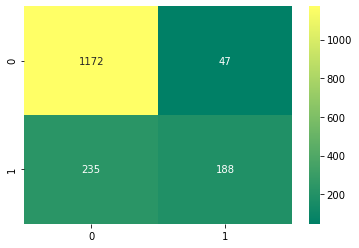


 Classification Report for SVM: 
                precision    recall  f1-score   support

           0       0.83      0.96      0.89      1219
           1       0.80      0.44      0.57       423

    accuracy                           0.83      1642
   macro avg       0.82      0.70      0.73      1642
weighted avg       0.82      0.83      0.81      1642



In [22]:
sns.heatmap(confusion_matrix(y,prediction),cmap='summer',annot=True,fmt='2.0f')
plt.show()
print("\n Classification Report for SVM: \n ",classification_report(y,prediction))

## Model Pipeline

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics

In [24]:
## Removes special strings and non text

class preprocess_text(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        if isinstance(X,pd.Series):
            X = X.copy()
            X = X.str.replace(r"http\S+", "")
            X = X.str.replace(r"http", "")
            X = X.str.replace(r"@\S+", "")
            X = X.str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
            X = X.str.replace(r"@", "at")
            X = X.str.lower()
            return X
        

In [25]:
pipe = Pipeline(verbose = True, steps = [('preprocessing', preprocess_text()),
                         ('tfidf',TfidfVectorizer()),
                          ('model', svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.1, kernel='linear',
                                      max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001, verbose=False))])

<IPython.core.display.Javascript object>

In [26]:
pipe.fit(X_train,y_train)

[Pipeline] ..... (step 1 of 3) Processing preprocessing, total=   0.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.2s


Pipeline(memory=None,
         steps=[('preprocessing', preprocess_text()),
                ('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
            

In [27]:
pipe_prediction = pipe.predict(X_test)

In [28]:
print(confusion_matrix(y_test,pipe_prediction))
print("\n\n")
print(classification_report(y_test,pipe_prediction))

[[354  17]
 [ 51  71]]



              precision    recall  f1-score   support

           0       0.87      0.95      0.91       371
           1       0.81      0.58      0.68       122

    accuracy                           0.86       493
   macro avg       0.84      0.77      0.79       493
weighted avg       0.86      0.86      0.85       493



In [29]:
pipe.predict(pd.Series(['Apple does work in a good manner']))


array([1], dtype=int64)

## Saving the Model

In [30]:
import pickle
 
pickle.dump(model_best, open('model.pkl', 'wb'))

ml_model = pickle.load(open('model.pkl', 'rb'))


In [31]:
pickle.dump(pipe, open('pipe.pkl','wb'))

ml_pipe = pickle.load(open('pipe.pkl', 'rb'))

In [32]:
ml_model

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [33]:
prediction = cross_val_predict(ml_model,X_tfidf,y, cv=10, verbose = 1,n_jobs =-1)
 
## Confusion matrix
conf_mat = confusion_matrix(y, prediction)
print('\nConfusion matrix = \n', conf_mat)
 
## Accuracy
print("Accuracy of model = ",metrics.accuracy_score(y, prediction))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Confusion matrix = 
 [[1172   47]
 [ 235  188]]
Accuracy of model =  0.8282582216808769


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


In [34]:
prediction = cross_val_predict(ml_pipe,X,y, cv=10, verbose = 1,n_jobs =-1)
 
## Confusion matrix
conf_mat = confusion_matrix(y, prediction)
print('\nConfusion matrix = \n', conf_mat)
 
## Accuracy
print("Accuracy of model = ",metrics.accuracy_score(y, prediction))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Confusion matrix = 
 [[1156   63]
 [ 219  204]]
Accuracy of model =  0.8282582216808769


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


## Conclusion

* We built a linear model that predicts the sentiment of tweets about Apple at around 83% accuracy. 
* The Confusion Matrix showed a tendency towards false negatives. Lastly we showed that the model succesfully inferred the importance of some english words to twitter sentiment.
* More and better data is needed to improve the model accuracy and also reduce it's bias to negative tweets.